In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
import scipy.stats
from IPython.display import HTML
import tqdm
%matplotlib inline

In [16]:
#勾配と偏微分
h = 1.0 * 10**-7
def grad_f(x,y):
    grad_x = (f(x + h, y) - f(x, y)) / h
    grad_y = (f(x, y + h) - f(x, y)) / h
    return [grad_x, grad_y]

def partial_grad_f(x,y,index):
    if index == 0:
        grad_x = (f(x + h, y) - f(x, y)) / h
        grad_y = 0
    else:
        grad_x = 0
        grad_y = (f(x, y + h) - f(x, y)) / h
    return [grad_x, grad_y]
    


In [21]:
#パラメータ更新
def optimize(x,y,step_num = 50, learning_rate=1e-2,momentum=0.8, mode ="GD"):
    start = (x,y)
    points = []
    if mode == "GD":
        for i in range(step_num+1):
            x,y = start
            gradient = grad_f(x,y)
            x_new = x - learning_rate * gradient[0]
            y_new = y - learning_rate * gradient[1]
            points.append([x,y,f(x,y)])
            start = (x_new,y_new)
    elif mode == "momentum":
        v_x, v_y = 0, 0 # the momentum point
        for i in range(step_num+1):
            x,y = start
            gradient = grad_f(x, y)
            v_x = momentum * v_x - learning_rate * gradient[0]
            v_y = momentum * v_y - learning_rate * gradient[1]
            x_new = x + v_x
            y_new = y + v_y
            points.append([x,y,f(x,y)])
            start = (x_new,y_new)
    elif mode == "ACDM":
        gamma = 1/8.0
        c= 1/8.0
        v_x, v_y = 0, 0 # the momentum point
        for i in range(step_num+1):
            gamma_temp = gamma
            gamma = math.sqrt(c**2+gamma_temp**2) + c
            alpha = gamma/(4.0*gamma_temp**2+gamma)
            random = scipy.stats.bernoulli.rvs(0.5)
            x,y = start
            gradient = partial_grad_f(alpha*v_x+(1.0-alpha)*x, alpha*v_y+(1.0-alpha)*y, random)
            x_new = alpha*v_x+(1.0-alpha)*x - learning_rate * gradient[0]
            y_new = alpha*v_y+(1.0-alpha)*y - learning_rate * gradient[1]
            v_x = v_x - gamma*learning_rate * gradient[0]
            v_y = v_y - gamma*learning_rate * gradient[1]
            points.append([x,y,f(x,y)])
            start = (x_new,y_new)
    elif mode == "exact_ACDM": #証明済みバージョン
        gamma = 1/8.0
        c= 1/8.0
        v_x, v_y = 0, 0 # the momentum point
        for i in range(step_num+1):
            gamma_temp = gamma
            gamma = math.sqrt(c**2+gamma_temp**2) + c
            alpha = gamma/(4.0*gamma_temp**2+gamma)
            random = scipy.stats.bernoulli.rvs(0.5)
            x,y = start
            gradient = partial_grad_f(alpha*v_x+(1.0-alpha)*x, alpha*v_y+(1.0-alpha)*y, random)
            x_exact, y_exact = alpha*v_x+(1.0-alpha)*x, alpha*v_y+(1.0-alpha)*y
            for _ in range(20): #10回更新した先をexactの解とする。
                exact_gradient = partial_grad_f(x_exact, y_exact, random)
                x_exact, y_exact = x_exact - exact_gradient[0], y_exact - exact_gradient[1]
            x_new = x_exact
            y_new = y_exact
            v_x = v_x - gamma*learning_rate * gradient[0]
            v_y = v_y - gamma*learning_rate * gradient[1]
            points.append([x,y,f(x,y)])
            start = (x_new,y_new)
    
    else:
        print("Error")
    return points
        
        
            



    
    

In [22]:
#グラフ関係の設定
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100).reshape(-1, 1)
#扱う関数
def f(x, y):
    return x**2 + y**2 + 50*x
#ハイパーパラメータ設定
hyperparameters={"x":50,
"y":50,
"step_num" : 50,
"learning_rate":1e-2,
"momentum":0.8}

GD_points = optimize(mode="GD", **hyperparameters)
momentum_points = optimize(mode="momentum", **hyperparameters)
ACDM_points = optimize(mode="ACDM",**hyperparameters)
exact_ACDM_points = optimize(mode="exact_ACDM",**hyperparameters)
def update(z):
    ax.cla() # ax をクリア
    ax.pcolormesh(x,y,f(x,y))
    ax.plot(GD_points[z][0],GD_points[z][1], "o", c="red", label="GD")
    ax.plot(momentum_points[z][0],momentum_points[z][1], "o", c="blue", label="momentum")
    ax.plot(ACDM_points[z][0],ACDM_points[z][1], "o", c="green",label="ACDM")
    ax.plot(exact_ACDM_points[z][0],ACDM_points[z][1], "o", c="yellow",label="exact_ACDM")
    ax.legend(loc="upper left")
anim = FuncAnimation(fig, update, frames=np.arange(hyperparameters["step_num"]), interval=200)

#anim.save("c03.gif", writer="imagemagick")
plt.close()
HTML(anim.to_jshtml())

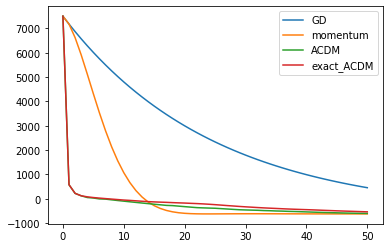

In [28]:
x = [i for i in range(len(GD_points))]
GD_points = pd.DataFrame(data=GD_points, columns=["x","y","loss"])
momentum_points = pd.DataFrame(data=momentum_points, columns=["x","y","loss"])
ACDM_points = pd.DataFrame(data=ACDM_points, columns=["x","y","loss"])
exact_ACDM_points = pd.DataFrame(data=exact_ACDM_points, columns=["x","y","loss"])
plt.plot(x, GD_points["loss"],label="GD")
plt.plot(x, momentum_points["loss"],label="momentum")
plt.plot(x, ACDM_points["loss"],label="ACDM")
plt.plot(x, exact_ACDM_points["loss"],label="exact_ACDM")
plt.legend(loc="best")
plt.show()